# Import Libraries

In [1]:
import numpy as np #type: ignore
import random
from collections import defaultdict
from IPython.display import clear_output #type: ignore
import tensorflow as tf #type: ignore
from tensorflow.keras import layers, models, regularizers #type: ignore
import os
from sklearn.model_selection import train_test_split #type: ignore
import matplotlib.pyplot as plt #type: ignore
from joblib import Parallel, delayed  # for parallelism
import multiprocessing

SEED = 22
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Connect Four and MCTS Code

In [2]:
def update_board(board_temp,color,column):
    board = board_temp.copy()
    colsum = abs(board[0,column])+abs(board[1,column])+abs(board[2,column])+abs(board[3,column])+abs(board[4,column])+abs(board[5,column])
    row = int(5-colsum)
    if row > -0.5:
        if color == 'plus':
            board[row,column] = 1
        else:
            board[row,column] = -1
    return board
    
def check_for_win_slow(board):
    nrow = board.shape[0]
    ncol = board.shape[1]
    winner = 'nobody'
    for col in range(ncol):
        for row in reversed(range(nrow)):
            if abs(board[row,col]) < 0.1:
                break
            # vertical
            if row <= (nrow-4):
                tempsum = board[row,col]+board[row+1,col]+board[row+2,col]+board[row+3,col]
                if tempsum==4:
                    winner = 'v-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'v-minus'
                    return winner
            # horizontal
            if col <= (ncol-4):
                tempsum = board[row,col]+board[row,col+1]+board[row,col+2]+board[row,col+3]
                if tempsum==4:
                    winner = 'h-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'h-minus'
                    return winner
            # diagonal down-right
            if (row <= (nrow-4)) and (col <= (ncol-4)):
                tempsum = board[row,col]+board[row+1,col+1]+board[row+2,col+2]+board[row+3,col+3]
                if tempsum==4:
                    winner = 'd-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'd-minus'
                    return winner
            # diagonal down-left
            if (row <= (nrow-4)) and (col >= 3):
                tempsum = board[row,col]+board[row+1,col-1]+board[row+2,col-2]+board[row+3,col-3]
                if tempsum==4:
                    winner = 'd-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'd-minus'
                    return winner
    return winner

def check_for_win(board,col):
    nrow = 6
    # figure out what row was just placed
    colsum = abs(board[0,col])+abs(board[1,col])+abs(board[2,col])+abs(board[3,col])+abs(board[4,col])+abs(board[5,col])
    row = int(6-colsum)
    # vertical check
    if row+3<6:
        vert = board[row,col] + board[row+1,col] + board[row+2,col] + board[row+3,col]
        if vert == 4:
            return 'v-plus'
        elif vert == -4:
            return 'v-minus'
    # horizontal checks (there are several)
    # segment 0-3
    if col+3<7:
        hor = board[row,col] + board[row,col+1] + board[row,col+2] + board[row,col+3]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # segment -1..+2
    if col-1>=0 and col+2<7:
        hor = board[row,col-1] + board[row,col] + board[row,col+1] + board[row,col+2]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # segment -2..+1
    if col-2>=0 and col+1<7:
        hor = board[row,col-2] + board[row,col-1] + board[row,col] + board[row,col+1]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # segment -3..0
    if col-3>=0:
        hor = board[row,col-3] + board[row,col-2] + board[row,col-1] + board[row,col]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    # diagonals down-right
    if row < 3 and col < 4:
        DR = board[row,col] + board[row+1,col+1] + board[row+2,col+2] + board[row+3,col+3]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-1>=0 and col-1>=0 and row+2<6 and col+2<7:
        DR = board[row-1,col-1] + board[row,col] + board[row+1,col+1] + board[row+2,col+2]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-2>=0 and col-2>=0 and row+1<6 and col+1<7:
        DR = board[row-2,col-2] + board[row-1,col-1] + board[row,col] + board[row+1,col+1]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-3>=0 and col-3>=0:
        DR = board[row-3,col-3] + board[row-2,col-2] + board[row-1,col-1] + board[row,col]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    # diagonals down-left
    if row+3<6 and col-3>=0:
        DL = board[row,col] + board[row+1,col-1] + board[row+2,col-2] + board[row+3,col-3]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-1>=0 and col+1<7 and row+2<6 and col-2>=0:
        DL = board[row-1,col+1] + board[row,col] + board[row+1,col-1] + board[row+2,col-2]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-2>=0 and col+2<7 and row+1<6 and col-1>=0:
        DL = board[row-2,col+2] + board[row-1,col+1] + board[row,col] + board[row+1,col-1]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-3>=0 and col+3<7:
        DL = board[row-3,col+3] + board[row-2,col+2] + board[row-1,col+1] + board[row,col]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    return 'nobody'

def find_legal(board):
    return [i for i in range(7) if abs(board[0,i]) < 0.1]

def look_for_win(board_,color):
    board_ = board_.copy()
    legal = find_legal(board_)
    winner_col = -1
    for m in legal:
        bt = update_board(board_.copy(),color,m)
        wi = check_for_win(bt,m)
        if wi[2:] == color:
            winner_col = m
            break
    return winner_col

def find_all_nonlosers(board,color):
    if color == 'plus':
        opp = 'minus'
    else:
        opp = 'plus'
    legal = find_legal(board)
    poss_boards = [update_board(board,color,l) for l in legal]
    poss_legal = [find_legal(b) for b in poss_boards]
    allowed = []
    for i in range(len(legal)):
        # if the opponent can immediately win after we move in col=legal[i], skip it
        wins = [j for j in poss_legal[i] 
                if check_for_win(update_board(poss_boards[i],opp,j),j) != 'nobody']
        if len(wins) == 0:
            allowed.append(legal[i])
    return allowed

def back_prop(winner,path,color0,md):
    for i, board_tuple in enumerate(path):
        md[board_tuple][0] += 1
        if winner[2] == color0[0]:
            if i % 2 == 1:
                md[board_tuple][1] += 1
            else:
                md[board_tuple][1] -= 1
        elif winner[2] == 'e':
            # tie => no change
            pass
        else:
            if i % 2 == 1:
                md[board_tuple][1] -= 1
            else:
                md[board_tuple][1] += 1

def rollout(board,next_player):
    winner = 'nobody'
    player = next_player
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            return 'tie'
        move = random.choice(legal)
        board = update_board(board,player,move)
        winner = check_for_win(board,move)
        # switch player
        if player == 'plus':
            player = 'minus'
        else:
            player = 'plus'
    return winner
        
def mcts(board_temp,color0,nsteps):
    # Traditional MCTS, plus small improvements:
    board = board_temp.copy()
    # 1. If there's an immediate winning move, use it
    win_col = look_for_win(board,color0)
    if win_col != -1:
        return win_col
    # 2. Look for any moves that avoid an immediate losing position
    legal0 = find_all_nonlosers(board,color0)
    if len(legal0) == 0:
        # if no way to avoid opponent's immediate threat, use all legal moves
        legal0 = find_legal(board)
    
    mcts_dict = {tuple(board.ravel()):[0,0]}
    for _ in range(nsteps):
        color = color0
        winner = 'nobody'
        board_mcts = board.copy()
        path = [tuple(board_mcts.ravel())]
        
        while winner == 'nobody':
            legal = find_legal(board_mcts)
            if len(legal) == 0:
                winner = 'tie'
                back_prop(winner,path,color0,mcts_dict)
                break
            # list of next possible boards
            board_list = []
            for col in legal:
                b_next = update_board(board_mcts,color,col)
                board_list.append(tuple(b_next.ravel()))
                if tuple(b_next.ravel()) not in mcts_dict:
                    mcts_dict[tuple(b_next.ravel())] = [0,0]
            
            # UCB1 
            ucb1 = np.zeros(len(legal))
            for i, bl in enumerate(board_list):
                num_sims, total_value = mcts_dict[bl]
                if num_sims == 0:
                    # large priority for unvisited
                    ucb1[i] = 10 * nsteps
                else:
                    parent_sims = mcts_dict[path[-1]][0]
                    avg_val = total_value / num_sims
                    explore = np.sqrt(np.log(parent_sims)/num_sims)
                    ucb1[i] = avg_val + 2*explore
            
            chosen = np.argmax(ucb1)
            board_mcts = update_board(board_mcts,color,legal[chosen])
            path.append(tuple(board_mcts.ravel()))
            # check winner
            winner = check_for_win(board_mcts,legal[chosen])
            if winner[2] == color[0]:
                back_prop(winner,path,color0,mcts_dict)
                break
            
            # switch player
            color = 'minus' if (color=='plus') else 'plus'
            
            # if the new board has never been visited, do a rollout
            if mcts_dict[tuple(board_mcts.ravel())][0] == 0:
                winner_roll = rollout(board_mcts,color)
                back_prop(winner_roll,path,color0,mcts_dict)
                break
    
    # pick the move with best average reward
    best_col = -1
    max_score = -np.inf
    for col in legal0:
        new_board = tuple(update_board(board,color0,col).ravel())
        num_sims, total_val = mcts_dict[new_board]
        if num_sims == 0:
            # means we never visited it
            score = -np.inf
        else:
            score = total_val/num_sims
        if score > max_score:
            max_score = score
            best_col = col

    return best_col


def board_to_6x7x2(board_2d):
    """
    Convert a 6x7 board with +1, -1, 0 
    into a 6x7x2 one-hot style representation:
       channel 0 => +1 positions
       channel 1 => -1 positions
    """
    X = np.zeros((6,7,2), dtype=np.float32)
    for i in range(6):
        for j in range(7):
            if board_2d[i,j] == 1:
                X[i,j,0] = 1
            elif board_2d[i,j] == -1:
                X[i,j,1] = 1
    return X

def minus_to_plus(board_6x7x2):
    """
    Flip a (6,7,2) board from 'minus perspective' to 'plus perspective'
    by swapping channels 0 and 1.
      channel 0 => +1 squares
      channel 1 => -1 squares
    If originally channel 1 was the 'minus' squares, 
    after swap, that becomes the 'plus' squares, etc.
    """
    flipped = board_6x7x2.copy()
    flipped[..., 0], flipped[..., 1] = board_6x7x2[..., 1], board_6x7x2[..., 0]
    return flipped

def add_symmetric_flips(board_6x7x2, best_move):
    """
    Given a (6,7,2) board and an integer best_move in [0..6],
    return a list of:
      [(original_board_6x7x2, best_move),
       (flipped_board_6x7x2, flipped_move)].
    The flipped version is mirrored left-to-right (column j -> 6-j).
    """
    out = []
    
    # 1) Original
    out.append((board_6x7x2, best_move))
    
    # 2) Flipped left-right
    flipped_board = board_6x7x2[:, ::-1, :].copy()
    flipped_col = 6 - best_move
    out.append((flipped_board, flipped_col))
    
    return out


# Building the Dataset

In [20]:
def play_one_game(plus_mcts_steps=800,
                  minus_mcts_steps=800,
                  random_openings=2):
    """
    Returns a list of (board_6x7x2, best_move, skill_level),
    where 'skill_level' is whichever MCTS steps were used.
    For 'minus', we also flip the board to plus perspective.
    We do NOT store random moves.
    """
    data_this_game = []
    board = np.zeros((6, 7), dtype=np.float32)
    winner = 'nobody'
    player = 'plus'
    move_count = 0

    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            break  # tie

        use_random = False
        if move_count < 2 * random_openings:
            use_random = True

        if use_random:
            col = random.choice(legal)
            skill_used = 0  # skill=0 for random (we won't store these anyway)
        else:
            if player == 'plus':
                col = mcts(board, 'plus', plus_mcts_steps)
                skill_used = plus_mcts_steps
            else:
                col = mcts(board, 'minus', minus_mcts_steps)
                skill_used = minus_mcts_steps

        old_board = board.copy()
        board = update_board(board, player, col)
        winner = check_for_win(board, col)

        if not use_random:
            if player == 'plus':
                board_6x7x2 = board_to_6x7x2(old_board)
                # store (board, move, skill)
                data_this_game.append((board_6x7x2, col, skill_used))
            else:
                board_6x7x2_minus = board_to_6x7x2(old_board)
                board_6x7x2_plus = minus_to_plus(board_6x7x2_minus)
                data_this_game.append((board_6x7x2_plus, col, skill_used))

        player = 'minus' if (player == 'plus') else 'plus'
        move_count += 1

    return data_this_game

def play_one_game_random_params():
    """
    Roll random settings for plus/minus MCTS [500..5000],
    and random_openings [1..15].
    Return list of (board_6x7x2, best_move, skill).
    """
    plus_mcts = random.randint(500, 5000)
    minus_mcts = random.randint(500, 5000)
    openings = random.randint(1, 15)
    game_data = play_one_game(
        plus_mcts_steps=plus_mcts,
        minus_mcts_steps=minus_mcts,
        random_openings=openings
    )
    return game_data  # list of (board, move, skill)

In [21]:
def parallel_build_dataset(num_games=25000):
    """
    Use joblib to run 'play_one_game_random_params()' in parallel.

    data_dict will map:
      key = (6,7,2) board .tobytes()
      => { 'best_skill': int,
           'move_counts': { move: (count) } }

    If a new skill > best_skill, override the entire move_counts with the new move.
    If skill == best_skill, we increment counts for that move as usual.
    If skill < best_skill, ignore it (we keep the higher skill's recommendation).
    """
    print(f"Building dataset with {num_games} games in parallel...")

    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(play_one_game_random_params)()
        for _ in range(num_games)
    )

    # data_dict: 
    #   key -> {'best_skill': X,
    #           'move_counts': {move -> count}}
    data_dict = defaultdict(lambda: {"best_skill": 0, "move_counts": defaultdict(int)})

    print("Aggregating results & handling collisions with skill priority...")

    for game_data in results:
        # game_data is list of (board_6x7x2, best_move, skill)
        for (board_6x7x2, best_move, skill_used) in game_data:
            # augment with symmetry
            augmented = add_symmetric_flips(board_6x7x2, best_move)

            for (b_aug, m_aug) in augmented:
                key = b_aug.tobytes()
                entry = data_dict[key]

                current_best_skill = entry["best_skill"]
                move_counts = entry["move_counts"]

                if skill_used > current_best_skill:
                    # override entire dictionary with new skill
                    # and reset move_counts
                    entry["best_skill"] = skill_used
                    entry["move_counts"] = defaultdict(int)
                    entry["move_counts"][m_aug] = 1
                elif skill_used == current_best_skill:
                    # same skill -> just increment
                    entry["move_counts"][m_aug] += 1
                else:
                    # skill_used < current_best_skill => ignore
                    pass

    # Now resolve collisions by picking the move with the highest count
    # for each board. We already only store moves from the highest skill.
    X_list = []
    y_list = []
    for key, val in data_dict.items():
        move_dict = val["move_counts"]
        # pick move with max count
        if len(move_dict) == 0:
            # might happen if skill=0 or something unexpected
            continue
        best_move = max(move_dict, key=move_dict.get)
        arr = np.frombuffer(key, dtype=np.float32).reshape(6,7,2)
        X_list.append(arr)
        y_list.append(best_move)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int32)

    return X, y

In [ ]:
if __name__ == "__main__":
    NUM_GAMES = 50000
    X, y = parallel_build_dataset(num_games=NUM_GAMES)
    print("Finished building dataset!")
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("Unique moves in y:", np.unique(y))

    # Save to disk
    np.save("X_dataset_ethan3.npy", X)
    np.save("y_dataset_ethan3.npy", y)
    print("Dataset saved to X_dataset_ethan3.npy and y_dataset_ethan3.npy.")

In [8]:
# Append dataset code

def append_datasets(file1_X, file1_y, file2_X, file2_y, out_X, out_y):
    """
    Load two Connect4 datasets (X1,y1) and (X2,y2),
    concatenate them along axis=0,
    then save as (out_X, out_y).
    """
    X1 = np.load(file1_X)
    y1 = np.load(file1_y)
    X2 = np.load(file2_X)
    y2 = np.load(file2_y)

    print("Before concatenation:")
    print("  Dataset 1:", X1.shape, y1.shape)
    print("  Dataset 2:", X2.shape, y2.shape)

    X_merged = np.concatenate([X1, X2], axis=0)
    y_merged = np.concatenate([y1, y2], axis=0)

    print("After concatenation:", X_merged.shape, y_merged.shape)

    np.save(out_X, X_merged)
    np.save(out_y, y_merged)
    print(f"Saved merged dataset to {out_X}, {out_y}.")

if __name__ == "__main__":
    # Example usage
    append_datasets(
        file1_X="X_dataset_ethan.npy",
        file1_y="y_dataset_ethan.npy",
        file2_X="X_dataset_ethan2.npy",
        file2_y="y_dataset_ethan2.npy",
        out_X="X_dataset_merged.npy",
        out_y="y_dataset_merged.npy"
    )

Before concatenation:
  Dataset 1: (457185, 6, 7, 2) (457185,)
  Dataset 2: (465707, 6, 7, 2) (465707,)
After concatenation: (922892, 6, 7, 2) (922892,)
Saved merged dataset to X_dataset_merged.npy, y_dataset_merged.npy.


# Data Splitting

In [3]:
X_file = "X_dataset_ethan3.npy"
y_file = "y_dataset_ethan3.npy"

X = np.load(X_file)  # shape (N, 6, 7, 2)
y = np.load(y_file)  # shape (N,)

print("Data shapes:")
print("X:", X.shape)
print("y:", y.shape)
unique_moves = np.unique(y)
print("Unique moves in y:", unique_moves)  # should be [0..6]

Data shapes:
X: (900019, 6, 7, 2)
y: (900019,)
Unique moves in y: [0 1 2 3 4 5 6]


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=22, 
    shuffle=True
)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])

Training set size: 720015
Validation set size: 180004


In [5]:
print("\nAvailable GPUs:", tf.config.list_physical_devices('GPU'))


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Training the CNN

In [13]:
def residual_block(x, filters, kernel_size=(3,3), l2_reg=1e-6):
    """
    A basic ResNet-style block:
      - 3x3 Conv -> BN -> ReLU
      - 3x3 Conv -> BN
      - skip connection
      - final ReLU
    """
    shortcut = x

    # 1st conv
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 2nd conv
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)

    # skip connection
    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

def build_resnet_bigger(
    input_shape=(6,7,2),
    num_classes=7,
    l2_reg=1e-6,
    dropout_rate=0.05
):
    """
    A bigger ResNet CNN for Connect 4.
    Architecture:
      1) Wide stem: conv(64)->(64) 
      2) 3 residual blocks at 64
      3) MaxPool
      4) Expand to 128
      5) 2 residual blocks at 128
      6) MaxPool
      7) 2 residual blocks at 128
      8) Expand to 256
      9) 2 residual blocks at 256
      10) Flatten
      11) Dense(1024)->BN->ReLU->Dropout
      12) Dense(512)->BN->ReLU->Dropout
      13) Output(7, softmax)
    """
    inputs = layers.Input(shape=input_shape)

    # ==============
    # 1. Wide Stem
    # ==============
    x = layers.Conv2D(64, (3,3), padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, (3,3), padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ==============
    # 2. 3 residual blocks at 64
    # ==============
    x = residual_block(x, filters=64,  l2_reg=l2_reg)
    x = residual_block(x, filters=64,  l2_reg=l2_reg)
    x = residual_block(x, filters=64,  l2_reg=l2_reg)

    # 3. MaxPool
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    # 4. Expand to 128
    x = layers.Conv2D(128, (1,1), padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 5. 2 residual blocks at 128
    x = residual_block(x, filters=128, l2_reg=l2_reg)
    x = residual_block(x, filters=128, l2_reg=l2_reg)

    # 6. MaxPool
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    # 7. 2 residual blocks at 128
    x = residual_block(x, filters=128, l2_reg=l2_reg)
    x = residual_block(x, filters=128, l2_reg=l2_reg)

    # ==============
    # 8. Expand to 256
    # ==============
    x = layers.Conv2D(256, (1,1), padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 9. 2 residual blocks at 256
    x = residual_block(x, filters=256, l2_reg=l2_reg)
    x = residual_block(x, filters=256, l2_reg=l2_reg)

    # flatten
    x = layers.Flatten()(x)

    # 11. Dense(1024)
    x = layers.Dense(1024, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    # 12. Dense(512)
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    # 13. Output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="ResNetBigger")
    return model

if __name__ == "__main__":
    cnn_model = build_resnet_bigger(
        input_shape=(6,7,2),
        num_classes=7,
        l2_reg=1e-6,
        dropout_rate=0.05 # maybe increase to 0.1 or 0.15?
    )

    cnn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # was 0.003
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    cnn_model.summary()

Model: "ResNetBigger"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 7, 2)]    0           []                               
                                                                                                  
 conv2d_22 (Conv2D)             (None, 6, 7, 64)     1216        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 6, 7, 64)    256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_24 (ReLU)                (None, 6, 7, 64)     0           ['batch_normalization_

In [14]:
epochs = 100
batch_size = 64

# Early stopping if val_accuracy doesn’t improve for 7 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

# Reduce learning rate by factor of 0.5 if val_accuracy doesn’t improve for 3 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

history = cnn_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
11251/11251 [==============================] - 156s 14ms/step - loss: 1.2488 - accuracy: 0.5237 - val_loss: 0.9558 - val_accuracy: 0.6377 - lr: 0.0070
Epoch 2/100
11251/11251 [==============================] - 153s 14ms/step - loss: 0.9407 - accuracy: 0.6488 - val_loss: 0.9086 - val_accuracy: 0.6640 - lr: 0.0070
Epoch 3/100
11251/11251 [==============================] - 153s 14ms/step - loss: 0.8987 - accuracy: 0.6676 - val_loss: 0.8976 - val_accuracy: 0.6675 - lr: 0.0070
Epoch 4/100
11251/11251 [==============================] - 153s 14ms/step - loss: 0.8787 - accuracy: 0.6762 - val_loss: 0.8829 - val_accuracy: 0.6742 - lr: 0.0070
Epoch 5/100
11251/11251 [==============================] - 153s 14ms/step - loss: 0.8665 - accuracy: 0.6809 - val_loss: 0.8550 - val_accuracy: 0.6830 - lr: 0.0070
Epoch 6/100
11251/11251 [==============================] - 152s 14ms/step - loss: 0.8570 - accuracy: 0.6850 - val_loss: 0.8479 - val_accuracy: 0.6873 - lr: 0.0070
Epoch 7/100
11251/1125

In [15]:
val_loss, val_acc = cnn_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc*100:.2f}%   (loss={val_loss:.4f})")

Validation accuracy: 72.45%   (loss=0.7331)


In [ ]:
#model.save("cnn_connect4.h5")
#print("Model saved to cnn_connect4.h5.")

Model saved to cnn_connect4.h5.


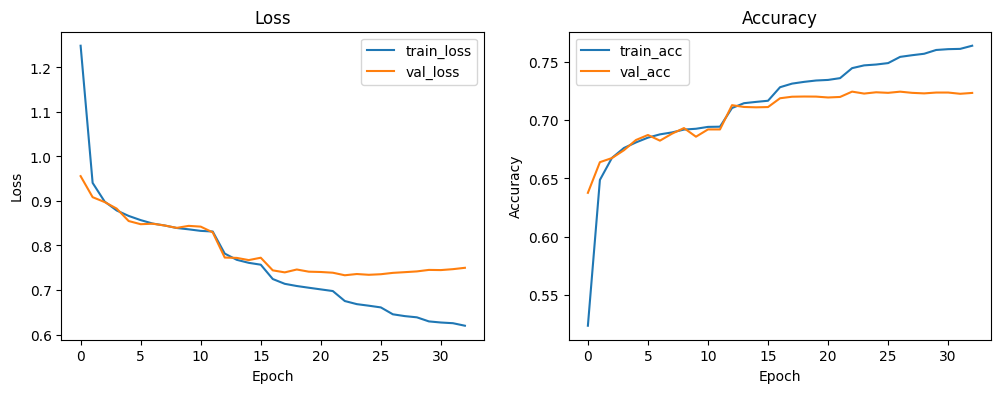

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
axs[0].plot(history.history['loss'], label='train_loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot accuracy
axs[1].plot(history.history['accuracy'], label='train_acc')
axs[1].plot(history.history['val_accuracy'], label='val_acc')
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

# Training the Transformer

In [6]:
class PositionalIndex(tf.keras.layers.Layer):
    """
    Produces a position index [0..seq_len-1] for each
    element in the batch, so we can embed positions.
    """
    def call(self, x):
        """
        x shape: (batch_size, seq_len, embed_dim)
        returns: (batch_size, seq_len) of indices
        """
        bs = tf.shape(x)[0]            # batch size
        seq_len = tf.shape(x)[1]       # how many patches in the sequence
        indices = tf.range(seq_len)    # [0..seq_len-1]
        indices = tf.expand_dims(indices, 0)    # shape (1, seq_len)
        return tf.tile(indices, [bs, 1])        # shape (bs, seq_len)

class ClassTokenIndex(tf.keras.layers.Layer):
    """
    Produces a single index (0) for each batch to embed
    a class token. We'll embed that index with a separate embedding.
    """
    def call(self, x):
        """
        x shape: (batch_size, seq_len, embed_dim)
        returns: (batch_size, 1)
        """
        bs = tf.shape(x)[0]
        # just a single index [0]
        idx = tf.zeros((1,1), dtype=tf.int32)   # shape (1,1)
        return tf.tile(idx, [bs, 1])           # shape (bs, 1)

In [7]:
def build_transformer_connect4_overlapping(
    input_shape=(6,7,2),
    hidden_dim=256,
    num_layers=8,
    num_heads=8,
    key_dim=None,
    mlp_dim=None,
    dropout_rate=0.15,
    num_classes=7,
    l2_reg=1e-4
):
    """
    A deeper Transformer for Connect4 with overlapping patches.

    Steps:
      1) Conv2D with kernel_size=3, stride=1 => overlapping patches:
         output shape => (4,5, hidden_dim) => 20 patches
      2) Flatten to (20, hidden_dim)
      3) Learn positional embedding for positions [0..19]
      4) Class token appended => total 21 tokens
      5) 8 Transformer blocks (Multi-head attention + MLP)
      6) Output on class token => Dense(7, softmax)

    Returns: compiled tf.keras.Model
    """
    if key_dim is None:
        key_dim = hidden_dim // num_heads
    if mlp_dim is None:
        mlp_dim = hidden_dim * 4  # typical factor of 4

    # 1) Overlapping patch embedding
    inputs = layers.Input(shape=input_shape)  # (None,6,7,2)
    # conv with stride=1 => shape => ((6-3+1)=4, (7-3+1)=5) => 4x5=20 patches
    patch_embed = layers.Conv2D(
        filters=hidden_dim,
        kernel_size=3,
        strides=1,
        padding='valid',
        kernel_regularizer=regularizers.l2(l2_reg)
    )(inputs)  # shape => (None,4,5, hidden_dim)
    # flatten => shape => (None, 20, hidden_dim)
    seq = layers.Reshape((-1, hidden_dim))(patch_embed)

    # 2) Positional embedding
    pos_indices = PositionalIndex()(seq)  # shape (bs, 20)
    pos_embed = layers.Embedding(
        input_dim=20,     # up to 20 patch positions
        output_dim=hidden_dim,
        embeddings_regularizer=regularizers.l2(l2_reg)
    )(pos_indices)        # (bs, 20, hidden_dim)

    x = layers.Add()([seq, pos_embed])  # shape => (bs,20,hidden_dim)

    # 3) Class token
    cls_idx = ClassTokenIndex()(x)  # shape => (bs,1)
    cls_token = layers.Embedding(
        input_dim=1,
        output_dim=hidden_dim,
        embeddings_regularizer=regularizers.l2(l2_reg)
    )(cls_idx)  # => (bs,1,hidden_dim)

    # concat => shape => (bs,21,hidden_dim)
    x = layers.Concatenate(axis=1)([cls_token, x])

    # 4) Stacked Transformer blocks
    for _ in range(num_layers):
        # LN + MHA
        ln1 = layers.LayerNormalization()(x)
        attn_out = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=key_dim,
            dropout=dropout_rate,
            kernel_regularizer=regularizers.l2(l2_reg),
            bias_regularizer=regularizers.l2(l2_reg),
        )(ln1, ln1, ln1)  # self-attention
        x = layers.Add()([x, attn_out])  # residual

        # LN + Feed-forward
        ln2 = layers.LayerNormalization()(x)
        ff = layers.Dense(
            mlp_dim, activation='gelu',
            kernel_regularizer=regularizers.l2(l2_reg)
        )(ln2)
        ff = layers.Dropout(dropout_rate)(ff)
        ff = layers.Dense(
            hidden_dim,
            kernel_regularizer=regularizers.l2(l2_reg)
        )(ff)
        ff = layers.Dropout(dropout_rate)(ff)
        x = layers.Add()([x, ff])  # residual

    # 5) Final classification on class token => x[:,0,:]
    cls_vec = x[:, 0, :]  # shape (bs, hidden_dim)
    ln = layers.LayerNormalization()(cls_vec)
    logits = layers.Dense(
        num_classes, activation='softmax',
        kernel_regularizer=regularizers.l2(l2_reg)
    )(ln)

    # compile
    model = models.Model(inputs, logits, name="ViT_Connect4_Overlapping")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
if __name__ == "__main__":
    print("Building an Overlapping-Patch Transformer for Connect4 shape (6,7,2)...")
    # You can tweak hidden_dim, num_layers, etc. further
    transformer_model = build_transformer_connect4_overlapping(
        input_shape=(6,7,2),
        hidden_dim=512, # Was 384
        num_layers=10,
        num_heads=8,
        key_dim=None,     # defaults to hidden_dim//num_heads # Was 48
        mlp_dim=None,     # defaults to 4*hidden_dim (was 384 but should have been 1536)
        dropout_rate=0.15, # was 0.1
        num_classes=7,    
        l2_reg=1e-3        # was 1e-4
    )

    transformer_model.summary()

Building an Overlapping-Patch Transformer for Connect4 shape (6,7,2)...
Model: "ViT_Connect4_Overlapping"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 7, 2)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 4, 5, 512)    9728        ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 20, 512)      0           ['conv2d[0][0]']                 
                                                                                                  
 positional_index (PositionalIn  (None, 20)          0           ['reshape[0][0]']                
 de

In [9]:
epochs = 200
batch_size = 128 #64

# Early stopping if val_accuracy doesn’t improve for 7 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

# Reduce learning rate by factor of 0.5 if val_accuracy doesn’t improve for 3 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

history = transformer_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/200
5626/5626 [==============================] - 299s 52ms/step - loss: 2.5556 - accuracy: 0.3955 - val_loss: 1.7970 - val_accuracy: 0.4433 - lr: 1.0000e-04
Epoch 2/200
5626/5626 [==============================] - 291s 52ms/step - loss: 1.5656 - accuracy: 0.4555 - val_loss: 1.4183 - val_accuracy: 0.4778 - lr: 1.0000e-04
Epoch 3/200
5626/5626 [==============================] - 291s 52ms/step - loss: 1.3888 - accuracy: 0.4807 - val_loss: 1.3378 - val_accuracy: 0.4964 - lr: 1.0000e-04
Epoch 4/200
5626/5626 [==============================] - 291s 52ms/step - loss: 1.3195 - accuracy: 0.5029 - val_loss: 1.2952 - val_accuracy: 0.5112 - lr: 1.0000e-04
Epoch 5/200
5626/5626 [==============================] - 291s 52ms/step - loss: 1.2656 - accuracy: 0.5256 - val_loss: 1.2263 - val_accuracy: 0.5418 - lr: 1.0000e-04
Epoch 6/200
5626/5626 [==============================] - 291s 52ms/step - loss: 1.2200 - accuracy: 0.5455 - val_loss: 1.1902 - val_accuracy: 0.5598 - lr: 1.0000e-04
Epoch 7/20

In [10]:
val_loss, val_acc = transformer_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc*100:.2f}%   (loss={val_loss:.4f})")

Validation accuracy: 67.64%   (loss=0.9626)


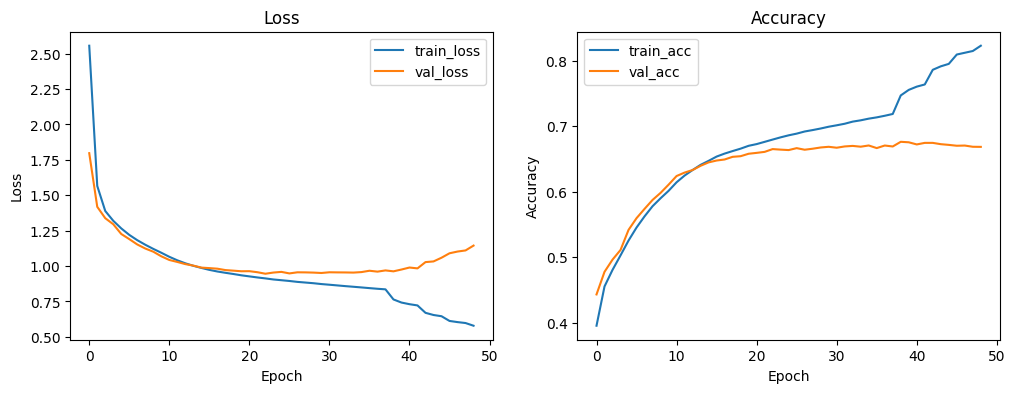

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
axs[0].plot(history.history['loss'], label='train_loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot accuracy
axs[1].plot(history.history['accuracy'], label='train_acc')
axs[1].plot(history.history['val_accuracy'], label='val_acc')
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

In [12]:
#transformer_model.save("ViT_Connect4_final.h5")
#print("Saved to ViT_Connect4_final.h5")

Saved to ViT_Connect4_final.h5


# Testing CNN and Transformer vs MCTS

In [13]:
class PositionalIndex(tf.keras.layers.Layer):
    """
    Produces a position index [0..seq_len-1] for each element in the batch,
    to embed positions.
    """
    def call(self, x):
        """
        x shape: (batch, seq_len, embed_dim)
        returns: (batch, seq_len) of indices
        """
        bs       = tf.shape(x)[0]
        seq_len  = tf.shape(x)[1]
        indices  = tf.range(seq_len)            # shape (seq_len,)
        indices  = tf.expand_dims(indices, 0)   # shape (1, seq_len)
        indices  = tf.tile(indices, [bs, 1])    # shape (bs, seq_len)
        return indices  # int32 by default

class ClassTokenIndex(tf.keras.layers.Layer):
    """
    Produces a single index (0) for each batch to embed a class token.
    """
    def call(self, x):
        """
        x shape: (batch, seq_len, embed_dim)
        returns: (batch, 1)
        """
        bs = tf.shape(x)[0]
        idx = tf.zeros((1,1), dtype=tf.int32)  # shape (1,1)
        return tf.tile(idx, [bs, 1])           # shape (bs, 1)

def build_transformer_connect4_overlapping(
    input_shape=(6,7,2),
    hidden_dim=256,
    num_layers=8,
    num_heads=8,
    key_dim=None,
    mlp_dim=None,
    dropout_rate=0.15,
    num_classes=7,
    l2_reg=1e-4
):
    """
    A deeper Transformer for Connect4 with overlapping patches.
    ...
    [Same code you posted]
    """
    if key_dim is None:
        key_dim = hidden_dim // num_heads
    if mlp_dim is None:
        mlp_dim = hidden_dim * 4  # typical factor of 4

    # 1) Overlapping patch embedding via Conv2D with stride=1 => shape => (4,5,hidden_dim)
    inputs = layers.Input(shape=input_shape)
    patch_embed = layers.Conv2D(
        filters=hidden_dim,
        kernel_size=3,
        strides=1,
        padding='valid',
        kernel_regularizer=regularizers.l2(l2_reg)
    )(inputs)  # => (None,4,5,hidden_dim)
    seq = layers.Reshape((-1, hidden_dim))(patch_embed)  # => (None,20,hidden_dim)

    # 2) Positional embedding
    pos_indices = PositionalIndex()(seq)  # => (batch,20)
    pos_embed = layers.Embedding(
        input_dim=20,
        output_dim=hidden_dim,
        embeddings_regularizer=regularizers.l2(l2_reg)
    )(pos_indices)  # => (batch,20,hidden_dim)
    x = layers.Add()([seq, pos_embed])    # => (batch,20,hidden_dim)

    # 3) Class token
    cls_idx = ClassTokenIndex()(x)  # => (batch,1)
    cls_token = layers.Embedding(
        input_dim=1,
        output_dim=hidden_dim,
        embeddings_regularizer=regularizers.l2(l2_reg)
    )(cls_idx)   # => (batch,1,hidden_dim)
    x = layers.Concatenate(axis=1)([cls_token, x])  # => (batch,21,hidden_dim)

    # 4) Stacked Transformer blocks
    for _ in range(num_layers):
        # LN + MHA
        ln1 = layers.LayerNormalization()(x)
        attn_out = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=key_dim,
            dropout=dropout_rate,
            kernel_regularizer=regularizers.l2(l2_reg),
            bias_regularizer=regularizers.l2(l2_reg)
        )(ln1, ln1, ln1)
        x = layers.Add()([x, attn_out])

        # LN + Feed-forward
        ln2 = layers.LayerNormalization()(x)
        ff = layers.Dense(
            mlp_dim, activation='gelu',
            kernel_regularizer=regularizers.l2(l2_reg)
        )(ln2)
        ff = layers.Dropout(dropout_rate)(ff)
        ff = layers.Dense(
            hidden_dim,
            kernel_regularizer=regularizers.l2(l2_reg)
        )(ff)
        ff = layers.Dropout(dropout_rate)(ff)
        x = layers.Add()([x, ff])

    # 5) Final classification (class token => x[:,0,:])
    cls_vec = x[:,0,:]  # => (batch, hidden_dim)
    ln = layers.LayerNormalization()(cls_vec)
    logits = layers.Dense(
        num_classes, activation='softmax',
        kernel_regularizer=regularizers.l2(l2_reg)
    )(ln)

    model = models.Model(inputs, logits, name="ViT_Connect4_Overlapping")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.007),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [14]:
cnn_model = tf.keras.models.load_model("cnn_connect4.h5")  # Adjust filename as needed

# Load the transformer model with custom objects
custom_objects = {
	'PositionalIndex': PositionalIndex,
	'ClassTokenIndex': ClassTokenIndex
}
#transformer_model = tf.keras.models.load_model("ViT_Connect4_final.h5", custom_objects=custom_objects)  # Adjust filename as needed

In [15]:
def cnn_pick_move(board_2d, model, color='plus'):
    """
    Given a 6x7 board (board_2d) and a trained CNN model,
    pick the column with the highest predicted probability that is legal.
    """
    # Convert board to 6x7x2 representation
    from_board = board_to_6x7x2(board_2d)
    
    if color == 'minus':
        # Flip to plus perspective
        from_board = minus_to_plus(from_board)

    # Model expects shape (N, 6, 7, 2). So expand dims.
    input_for_model = np.expand_dims(from_board, axis=0)  # (1,6,7,2)
    
    # Predict probabilities for each column
    pred_probs = model.predict(input_for_model, verbose=0)[0]  # (7,)
    
    # Sort columns by descending probability
    columns_ranked = np.argsort(pred_probs)[::-1]  # highest -> lowest
    
    # Find a legal column among the top predictions
    legal_cols = find_legal(board_2d)
    for col in columns_ranked:
        if col in legal_cols:
            return col
    
    # Fallback: pick a random legal column
    if len(legal_cols) > 0:
        return random.choice(legal_cols)
    else:
        return 0  # If no columns are legal, default to column 0

def transformer_pick_move(board_2d, model, color='plus'):
    """
    Given a 6x7 board (board_2d) and a trained Transformer model,
    pick the column with the highest predicted probability that is legal.
    """
    # Convert board to 6x7x2 representation
    from_board = board_to_6x7x2(board_2d)
    
    if color == 'minus':
        # Flip to plus perspective
        from_board = minus_to_plus(from_board)

    # Model expects shape (N, 6, 7, 2). So expand dims.
    input_for_model = np.expand_dims(from_board, axis=0)  # (1,6,7,2)
    
    # Predict probabilities for each column
    pred_probs = model.predict(input_for_model, verbose=0)[0]  # (7,)
    
    # Sort columns by descending probability
    columns_ranked = np.argsort(pred_probs)[::-1]  # highest -> lowest
    
    # Find a legal column among the top predictions
    legal_cols = find_legal(board_2d)
    for col in columns_ranked:
        if col in legal_cols:
            return col
    
    # Fallback: pick a random legal column
    if len(legal_cols) > 0:
        return random.choice(legal_cols)
    else:
        return 0  # If no columns are legal, default to column 0


In [16]:
def play_one_game(model_pick_move, model_type='CNN', mcts_steps_minus=300, verbose=False):
    """
    Let either the CNN or Transformer play as 'plus' against MCTS as 'minus'.
    
    Parameters:
    - model_pick_move: function to pick moves using the model (cnn_pick_move or transformer_pick_move)
    - model_type: 'CNN' or 'Transformer' (for reporting purposes)
    - mcts_steps_minus: number of MCTS steps for the 'minus' player
    - verbose: if True, print each move
    
    Returns:
    - winner: 'plus', 'minus', or 'tie'
    - move_count: number of moves made in the game
    """
    board = np.zeros((6,7), dtype=np.float32)
    winner = 'nobody'
    player = 'plus'
    move_count = 0

    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            # Tie
            break

        if player == 'plus':
            col = model_pick_move(board, model=cnn_model if model_type == 'CNN' else transformer_model, color='plus')
        else:
            col = mcts(board, 'minus', mcts_steps_minus)

        board = update_board(board, player, col)
        winner = check_for_win(board, col)
        move_count += 1

        if verbose:
            print(f"Move {move_count}, {player}, col={col}")

        # Switch player
        player = 'minus' if player == 'plus' else 'plus'

    # Determine outcome
    if winner == 'nobody' or winner == 'tie':
        return 'tie', move_count
    elif winner.endswith('plus'):
        return 'plus', move_count
    elif winner.endswith('minus'):
        return 'minus', move_count
    else:
        return 'tie', move_count  # Default to tie if unclear

def test_model_vs_MCTS(model_pick_move, model_type='CNN', num_games=100, mcts_steps_minus=300, verbose=False):
    """
    Play multiple games between the specified model and MCTS.
    
    Parameters:
    - model_pick_move: function to pick moves using the model
    - model_type: 'CNN' or 'Transformer'
    - num_games: number of games to play
    - mcts_steps_minus: number of MCTS steps for the 'minus' player
    - verbose: if True, print game outcomes
    
    Returns:
    - results: dict with counts of 'plus_wins', 'minus_wins', 'ties', 'avg_moves'
    """
    plus_wins = 0
    minus_wins = 0
    ties = 0
    total_moves = 0

    for g in range(1, num_games + 1):
        winner, moves = play_one_game(model_pick_move, model_type, mcts_steps_minus, verbose)
        total_moves += moves

        if winner == 'plus':
            plus_wins += 1
        elif winner == 'minus':
            minus_wins += 1
        else:
            ties += 1

        if verbose:
            print(f"Game {g}: Winner = {winner}, Moves = {moves}")

    avg_moves = total_moves / num_games if num_games > 0 else 0

    results = {
        'plus_wins': plus_wins,
        'minus_wins': minus_wins,
        'ties': ties,
        'avg_moves': avg_moves
    }

    return results

In [17]:
if __name__ == "__main__":
    # Define evaluation parameters
    num_games = 50
    mcts_steps = 1000  # Number of MCTS steps for the 'minus' player

    # Evaluate CNN vs MCTS
    #print("Evaluating CNN vs MCTS...")
    #results_cnn = test_model_vs_MCTS(
    #    model_pick_move=cnn_pick_move,      # function to pick CNN moves
    #    model_type='CNN',                  # label for logging
    #    num_games=num_games,
    #    mcts_steps_minus=mcts_steps,
    #    verbose=False
    #)
    #print(f"Out of {num_games} games vs. MCTS({mcts_steps} steps):")
    #print(f"  CNN (plus) wins:  {results_cnn['plus_wins']}")
    #print(f"  MCTS (minus) wins: {results_cnn['minus_wins']}")
    #print(f"  Ties: {results_cnn['ties']}")
    #print(f"  Average number of moves per game: {results_cnn['avg_moves']:.1f}\n")

    # Evaluate Transformer vs MCTS
    print("Evaluating Transformer vs MCTS...")
    results_transformer = test_model_vs_MCTS(
        model_pick_move=transformer_pick_move,  # function to pick Transformer moves
        model_type='Transformer',               # label for logging
        num_games=num_games,
        mcts_steps_minus=mcts_steps,
        verbose=False
    )
    print(f"Out of {num_games} games vs. MCTS({mcts_steps} steps):")
    print(f"  Transformer (plus) wins:  {results_transformer['plus_wins']}")
    print(f"  MCTS (minus) wins:        {results_transformer['minus_wins']}")
    print(f"  Ties:                     {results_transformer['ties']}")
    print(f"  Average number of moves per game: {results_transformer['avg_moves']:.1f}\n")

Evaluating CNN vs MCTS...
Out of 50 games vs. MCTS(1000 steps):
  CNN (plus) wins:  35
  MCTS (minus) wins: 14
  Ties: 1
  Average number of moves per game: 31.6

Evaluating Transformer vs MCTS...
Out of 50 games vs. MCTS(1000 steps):
  Transformer (plus) wins:  37
  MCTS (minus) wins:        11
  Ties:                     2
  Average number of moves per game: 29.6

